# Introduction

## Imports and settings

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import re
from scipy.fftpack import fft
import pickle
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.stattools import acf

from statsmodels.tsa.arima_model import ARIMA
import warnings


/home/allen/.conda/envs/deep_learn/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


## Loading Data

Keys.csv contains only the hashed identification for each page, which is only needed for submission. Hence we will only be loading the relevant data.

In [2]:
data = pd.read_csv('data/train_1.csv')

## Data Structure

In [3]:
data.head()

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,...,32.0,63.0,15.0,26.0,14.0,20.0,22.0,19.0,18.0,20.0
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,...,17.0,42.0,28.0,15.0,9.0,30.0,52.0,45.0,26.0,20.0
2,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,...,3.0,1.0,1.0,7.0,4.0,4.0,6.0,3.0,4.0,17.0
3,4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,...,32.0,10.0,26.0,27.0,16.0,11.0,17.0,19.0,10.0,11.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,48.0,9.0,25.0,13.0,3.0,11.0,27.0,13.0,36.0,10.0


The Page title provides us useful information:
-Title
-Kind of access(agent, spider, desktop)
-Country
-Site (wikimedia, wikipedia, etc.)

We can extract this information for some feature engeneering.


TimeSeries also seems to display a lot of NaN values. Better fill them when loading csv.

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145063 entries, 0 to 145062
Columns: 551 entries, Page to 2016-12-31
dtypes: float64(550), object(1)
memory usage: 609.8+ MB


Data is kind of large, and might run into some problems with a low memory computer (4gb ram).

Notebook moved to a google cloud instance.

## Missing values

In [9]:
nan_count = data.isnull().sum()

In [15]:
nan_count

Page              0
2015-07-01    20740
2015-07-02    20816
2015-07-03    20544
2015-07-04    20654
2015-07-05    20659
2015-07-06    20483
2015-07-07    20664
2015-07-08    20294
2015-07-09    20244
2015-07-10    20342
2015-07-11    20525
2015-07-12    20485
2015-07-13    20399
2015-07-14    20140
2015-07-15    20106
2015-07-16    19987
2015-07-17    20048
2015-07-18    20295
2015-07-19    20142
2015-07-20    19979
2015-07-21    19688
2015-07-22    19573
2015-07-23    19581
2015-07-24    19593
2015-07-25    19589
2015-07-26    19865
2015-07-27    19759
2015-07-28    19553
2015-07-29    19347
              ...  
2016-12-02     4243
2016-12-03     3675
2016-12-04     4290
2016-12-05     4231
2016-12-06     4103
2016-12-07     4130
2016-12-08     3962
2016-12-09     4179
2016-12-10     3625
2016-12-11     3581
2016-12-12     3538
2016-12-13     3802
2016-12-14     4108
2016-12-15     4078
2016-12-16     3566
2016-12-17     3559
2016-12-18     3666
2016-12-19     3652
2016-12-20     3268


In [14]:
sum(nan_count) / (data.shape[0] * (data.shape[1]-1))

0.07762058240526216

About 8% of the values are NaN. We can see that the majority of NaN values are at the beggining of our data, and steadily decreases as time advances. 

These missing values have to be treated.

Possible strategies:

-Drop series with too much NaN values specified by threshold

-Impute values with a baseline ARIMA prediction

# Data Transformation and Helper Functions

As stated above, the page feature can give us a lot of relevant information. We'll use regular expressions to match the words we want to capture.

In [16]:
# extracting country, agent, site
# ?:foobar, foobar as a non capturing group

pat = re.compile(
    '(.+)_([a-z]{2}\.)?((?:wikipedia\.org)|(?:commons\.wikimedia\.org)|(?:www\.wikimedia\.org)|(?:www\.mediawiki\.org))_([a-z_-]+?)$'
)
print(pat.fullmatch('BLEACH_zh.wikipedia.org_all-accessspider').groups())
print(pat.fullmatch('Accueil_commons.wikimedia.org_all-access_spider').groups())


('BLEACH', 'zh.', 'wikipedia.org', 'all-accessspider')
('Accueil', None, 'commons.wikimedia.org', 'all-access_spider')


In [17]:
print(pat.fullmatch('"Keep_me_logged_in"_extended_to_one_year_www.mediawiki.org_all-access_all-agents').groups())

('"Keep_me_logged_in"_extended_to_one_year', None, 'www.mediawiki.org', 'all-access_all-agents')


In [18]:
def extract_from_url(urls):
    '''
    receives pandas dataframe column or series
    returns a pandas dataframe with all the extracted features
    '''
    
    if isinstance(urls, pd.Series):
         urls = urls.values
    
    agents = np.full_like(urls, np.NaN)
    sites = np.full_like(urls, np.NaN)
    countries = np.full_like(urls, np.NaN)
    titles = np.full_like(urls, np.nan)
    
    for i in range(len(urls)):
        url = urls[i]
        match = pat.fullmatch(url)
        assert match, "regex pattern matching failed %s" % url
        
        title = match.group(1)
        titles[i] = title
        
        country = match.group(2)
        if country:
            countries[i] = country[:-1]
        else:
            countries[i] = 'na'
            
        site = match.group(3)
        sites[i] = site
        
        agent = match.group(4)
        agents[i] = agent
        
    return pd.DataFrame({
        'page': urls,
        'title': titles,
        'agent': agents,
        'site': sites,
        'country': countries,
    })

urls = data.Page
extract = extract_from_url(urls)

In [19]:
extract.head()

,agent,country,page,site,title
0,all-access_spider,zh,2NE1_zh.wikipedia.org_all-access_spider,wikipedia.org,2NE1
1,all-access_spider,zh,2PM_zh.wikipedia.org_all-access_spider,wikipedia.org,2PM
2,all-access_spider,zh,3C_zh.wikipedia.org_all-access_spider,wikipedia.org,3C
3,all-access_spider,zh,4minute_zh.wikipedia.org_all-access_spider,wikipedia.org,4minute
4,all-access_spider,zh,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,wikipedia.org,52_Hz_I_Love_You


In [72]:
extract.country.value_counts()

en    24108
ja    20431
de    18547
na    17855
fr    17802
zh    17229
ru    15022
es    14069
Name: country, dtype: int64

In [ ]:
def plot_series(start, end, series):
    pass

# Parameters analysis

Before delving deeper into the data, let's see what kind of accesses these pages are getting, if most traffic is mobile or desktop, and how representative each country is.

# Data Visualization

## By Language

Different cultures, different customs! We'll get a nice first overlook at the data aggregated by country, and check if there is any underlying phenomena unique to each country. 

Is periodicity the same for all countries?
Any trends unique to any country?

We'll proceed to more specific data as we progress.

In [74]:
data['lang'] = extract.country

In [75]:
data.head()

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31,lang
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,...,63.0,15.0,26.0,14.0,20.0,22.0,19.0,18.0,20.0,zh
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,...,42.0,28.0,15.0,9.0,30.0,52.0,45.0,26.0,20.0,zh
2,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,...,1.0,1.0,7.0,4.0,4.0,6.0,3.0,4.0,17.0,zh
3,4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,...,10.0,26.0,27.0,16.0,11.0,17.0,19.0,10.0,11.0,zh
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,9.0,25.0,13.0,3.0,11.0,27.0,13.0,36.0,10.0,zh


In [76]:
data.fillna(0)
data.head()

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31,lang
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,...,63.0,15.0,26.0,14.0,20.0,22.0,19.0,18.0,20.0,zh
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,...,42.0,28.0,15.0,9.0,30.0,52.0,45.0,26.0,20.0,zh
2,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,...,1.0,1.0,7.0,4.0,4.0,6.0,3.0,4.0,17.0,zh
3,4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,...,10.0,26.0,27.0,16.0,11.0,17.0,19.0,10.0,11.0,zh
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,9.0,25.0,13.0,3.0,11.0,27.0,13.0,36.0,10.0,zh


In [45]:
lang_sets = {}
lang_sets['en'] = data[data.lang =='en'].iloc[:, 0:-2]
lang_sets['ja'] = data[data.lang =='ja'].iloc[:, 0:-2]
lang_sets['de'] = data[data.lang =='de'].iloc[:, 0:-2]
lang_sets['fr'] = data[data.lang =='fr'].iloc[:, 0:-2]
lang_sets['zh'] = data[data.lang =='zh'].iloc[:, 0:-2]
lang_sets['ru'] = data[data.lang =='ru'].iloc[:, 0:-2]
lang_sets['es'] = data[data.lang =='es'].iloc[:, 0:-2]
lang_sets['na'] = data[data.lang =='na'].iloc[:, 0:-2]

In [46]:
sums = {}
for key in lang_sets:
    sums[key] = lang_sets[key].iloc[:, 1:].sum(axis=0) / lang_sets[key].shape[0]

In [47]:
labels={'en':'English','ja':'Japanese','de':'German',
        'na':'Media','fr':'French','zh':'Chinese',
        'ru':'Russian','es':'Spanish'
       }


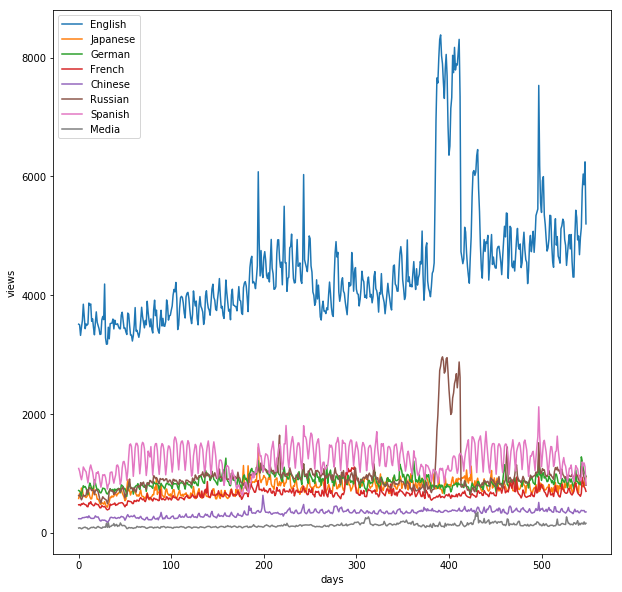

In [48]:
days = [r for r in range(sums['en'].shape[0])]

fig = plt.figure(1, figsize=[10, 10])
plt.ylabel('views')
plt.xlabel('days')


for key in sums:
    plt.plot(days, sums[key], label = labels[key])
    
plt.legend()
plt.show()

### Observations

We can clearly see that the english wiki has more page hits, as expected.

Both the english and russian wikis display a huge spike around day 400, indicating that normalizing the data might be useful in order to get rid of these outliers.

The spanish wiki displays a larger variance than all of the other wikis (besides the english one). 

A first look at this indicates that data is majorly stationary.

### Decisions

Normalize data with log1p() transform as suggested by 1st place solution.

## Top Pages for each wiki

In [49]:
n_pages = 5
top_pages = {}

for key in lang_sets:
    print(key)
    sum_set = pd.DataFrame(lang_sets[key][['Page']])
    sum_set['total'] = lang_sets[key].sum(axis=1)
    sum_set = sum_set.sort_values('total', ascending=False)
    print(sum_set.head(10))
    top_pages[key] = sum_set.index[0]
    print('\n\n')

en
                                                    Page         total
38573   Main_Page_en.wikipedia.org_all-access_all-agents  1.204003e+10
9774       Main_Page_en.wikipedia.org_desktop_all-agents  8.754906e+09
74114   Main_Page_en.wikipedia.org_mobile-web_all-agents  3.150045e+09
39180  Special:Search_en.wikipedia.org_all-access_all...  1.302502e+09
10403  Special:Search_en.wikipedia.org_desktop_all-ag...  1.010672e+09
74690  Special:Search_en.wikipedia.org_mobile-web_all...  2.917619e+08
39172  Special:Book_en.wikipedia.org_all-access_all-a...  1.335657e+08
10399   Special:Book_en.wikipedia.org_desktop_all-agents  1.328590e+08
33644       Main_Page_en.wikipedia.org_all-access_spider  1.289433e+08
34257  Special:Search_en.wikipedia.org_all-access_spider  1.241589e+08



ja
                                                     Page        total
120336      メインページ_ja.wikipedia.org_all-access_all-agents  210254229.0
86431          メインページ_ja.wikipedia.org_desktop_all-agents  133948459

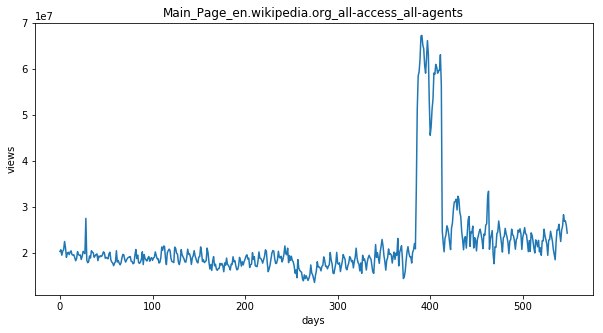

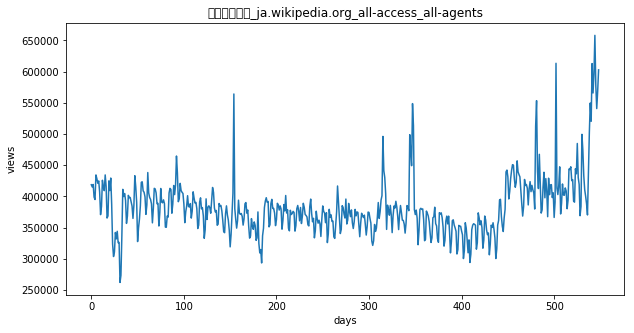

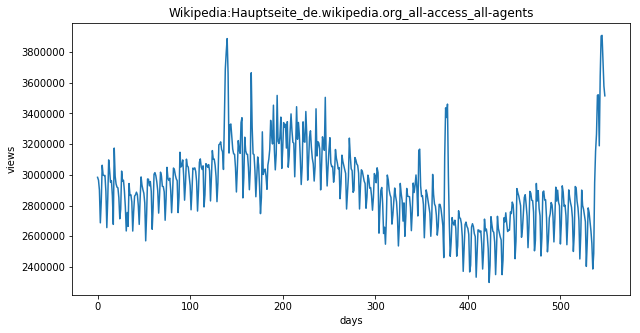

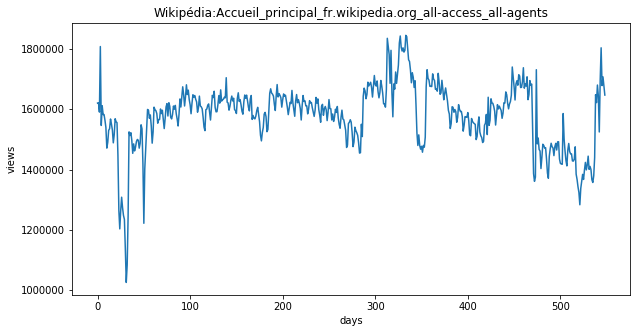

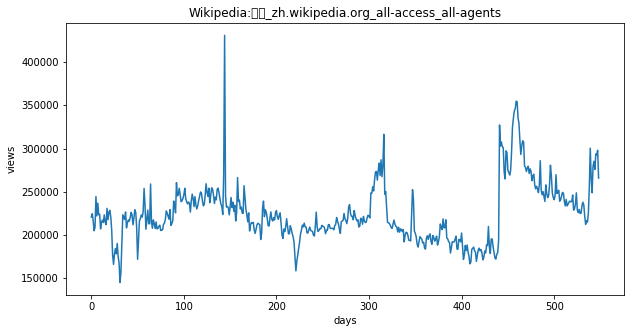

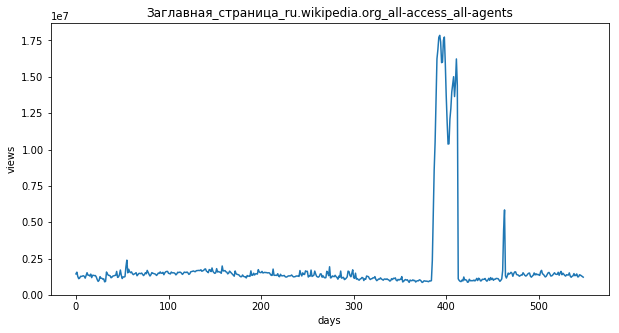

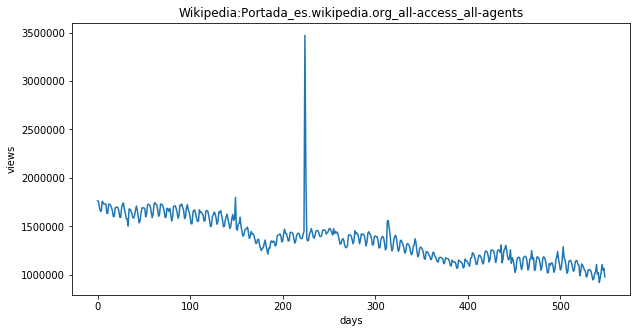

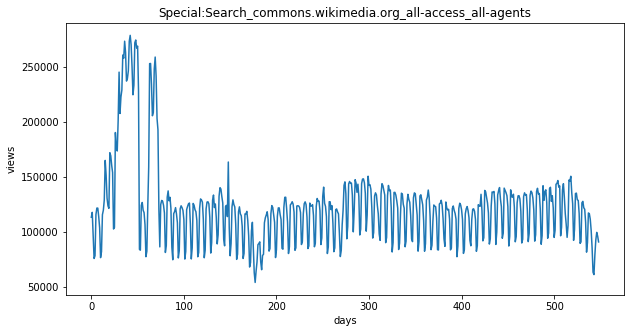

In [50]:
for key in top_pages:
    fig = plt.figure(1, figsize=(10,5))
    plt.xlabel('days')
    plt.ylabel('views')
    plt.title(data.loc[top_pages[key], 'Page'])
    
    cols = data.columns
    cols = cols[1:-2]
    df = data.loc[top_pages[key], cols]
    plt.plot(days, df)
    plt.show()

## Individual Entries

In [51]:
def plot_entry(key, idx):
    article = lang_sets[key].iloc[idx, 1:]
    
    fig = plt.figure(1, figsize=(10,5))
    plt.plot(days, article)
    plt.xlabel('days')
    plt.ylabel('views')
    plt.title(data.iloc[lang_sets[key].index[idx],0])
    
    plt.show()

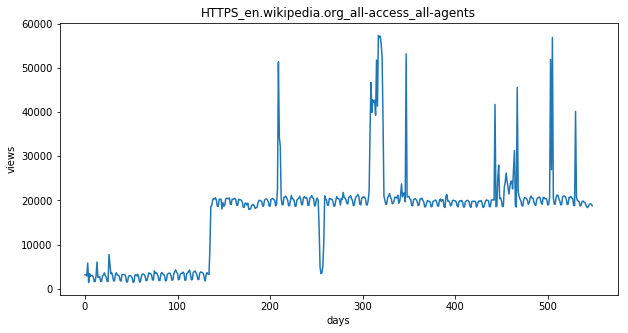

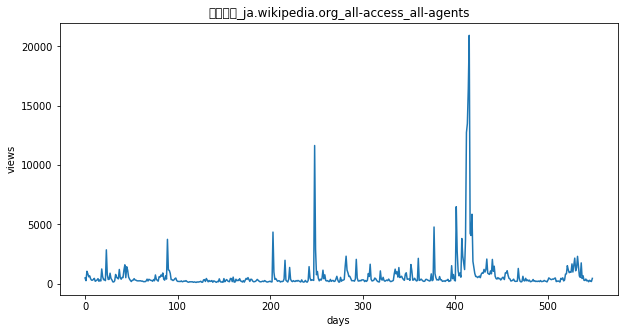

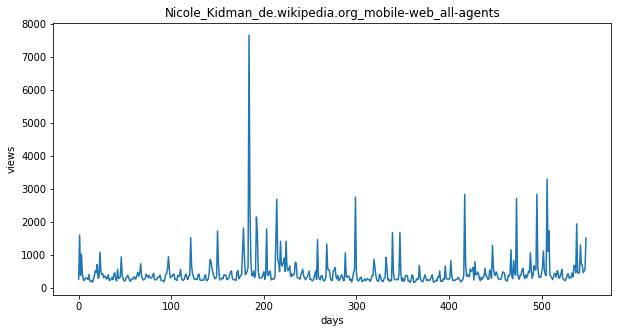

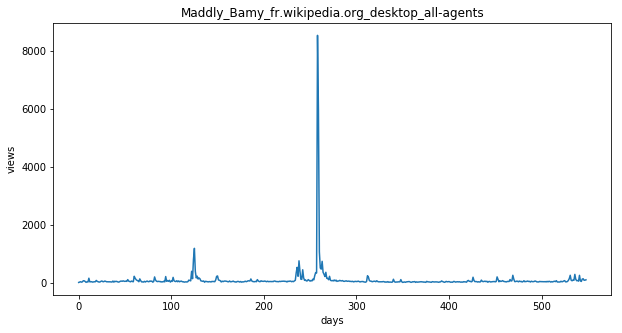

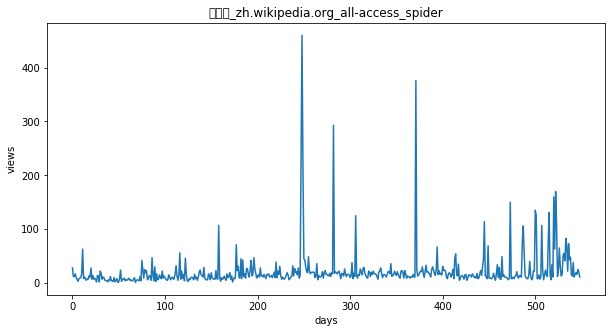

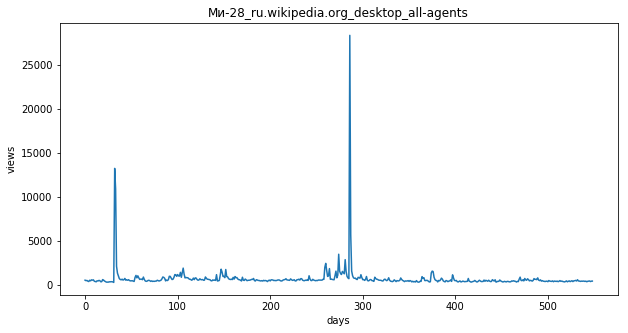

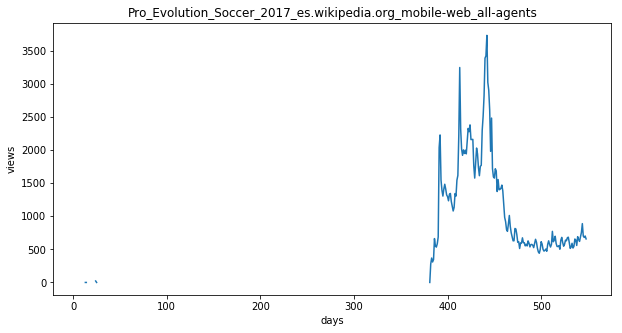

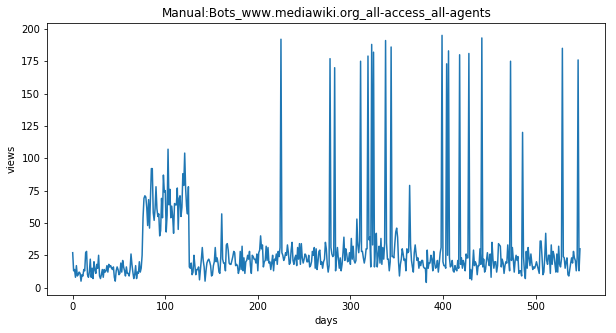

In [52]:
for key in lang_sets:
    rnd_idx = np.random.randint(lang_sets[key].shape[0])
    plot_entry(key, rnd_idx)

# Stationarity Analysis

In [61]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries, window=30):
    #rolling statistics
    rol_mean = timeseries.rolling(window=window).mean()
    rol_std = timeseries.rolling(window=window).std()
    
    #plot rolling statistics
    orig = plt.plot(timeseries, color='blue', label='orig')
    mean = plt.plot(rol_mean, color='red', label='mean')
    std = plt.plot(rol_std, color='black', label='std')
    plt.legend(loc='best')
    
    plt.title('rolling means and std')
    plt.show(block=False)
    
    #dickey fuller test
    print('fuller test')
    df_test = adfuller(timeseries, autolag='AIC')
    df_output = pd.Series(df_test[0:4], index=['Test Statistic', 'p-value', '#lags used', '#observations used'])
    
    for key, value in df_test[4].items():
        df_output['critical value (%s)' %key] = value
    print(df_output)

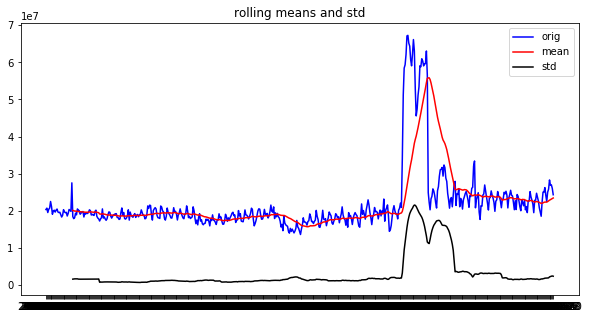

fuller test
Test Statistic           -2.997309
p-value                   0.035147
#lags used               15.000000
#observations used      533.000000
critical value (1%)      -3.442678
critical value (5%)      -2.866978
critical value (10%)     -2.569666
dtype: float64


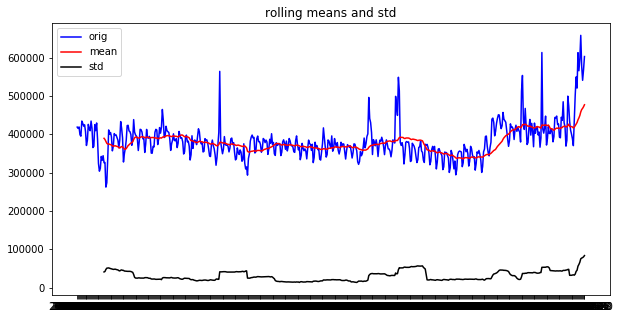

fuller test
Test Statistic           -1.079897
p-value                   0.723022
#lags used               14.000000
#observations used      534.000000
critical value (1%)      -3.442655
critical value (5%)      -2.866968
critical value (10%)     -2.569661
dtype: float64


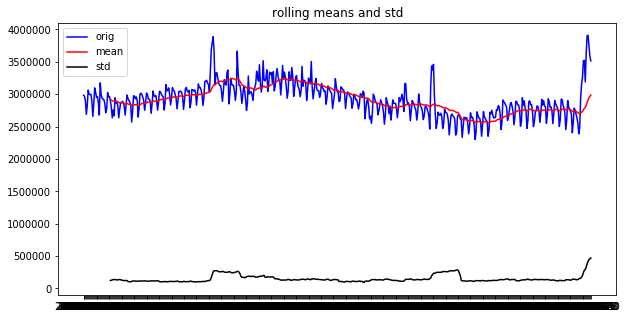

fuller test
Test Statistic           -1.536740
p-value                   0.515265
#lags used               19.000000
#observations used      529.000000
critical value (1%)      -3.442772
critical value (5%)      -2.867019
critical value (10%)     -2.569688
dtype: float64


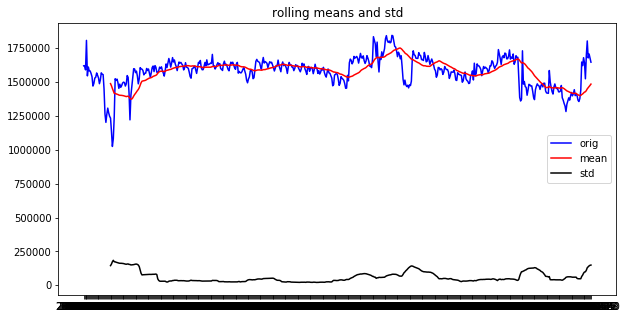

fuller test
Test Statistic           -3.580455
p-value                   0.006146
#lags used               14.000000
#observations used      534.000000
critical value (1%)      -3.442655
critical value (5%)      -2.866968
critical value (10%)     -2.569661
dtype: float64


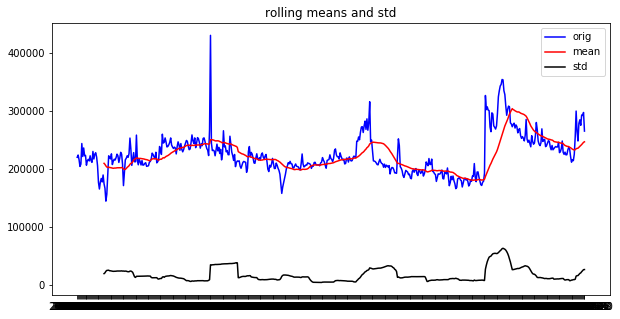

fuller test
Test Statistic           -2.648631
p-value                   0.083357
#lags used               14.000000
#observations used      534.000000
critical value (1%)      -3.442655
critical value (5%)      -2.866968
critical value (10%)     -2.569661
dtype: float64


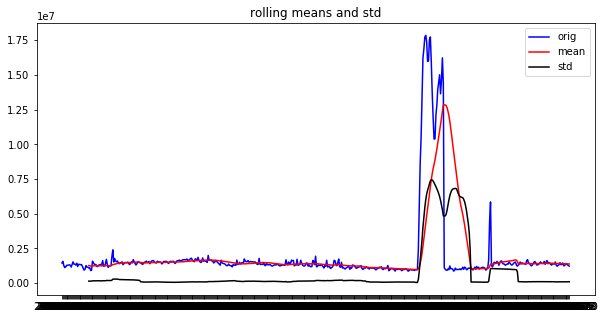

fuller test
Test Statistic           -4.125663
p-value                   0.000878
#lags used                4.000000
#observations used      544.000000
critical value (1%)      -3.442428
critical value (5%)      -2.866868
critical value (10%)     -2.569607
dtype: float64


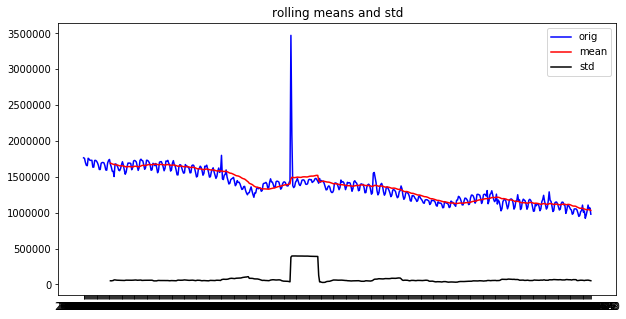

fuller test
Test Statistic           -1.000749
p-value                   0.752991
#lags used               13.000000
#observations used      535.000000
critical value (1%)      -3.442632
critical value (5%)      -2.866957
critical value (10%)     -2.569655
dtype: float64


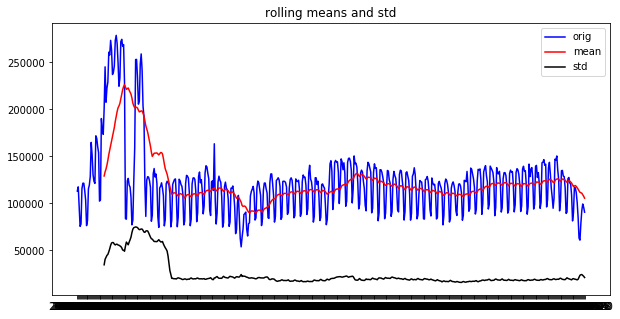

fuller test
Test Statistic           -2.984770
p-value                   0.036341
#lags used               15.000000
#observations used      533.000000
critical value (1%)      -3.442678
critical value (5%)      -2.866978
critical value (10%)     -2.569666
dtype: float64


In [67]:
for key in top_pages:
    fig = plt.figure(1, figsize=(10,5))
    
    
    cols = data.columns
    cols = cols[1:-2]
    df = data.loc[top_pages[key], cols]
    test_stationarity(df)

# Decomposition

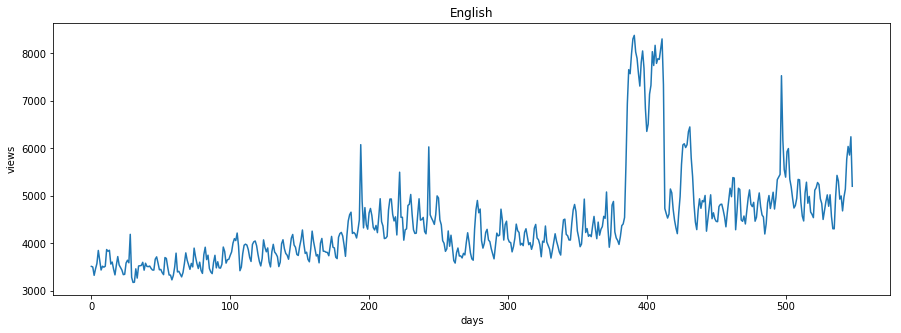

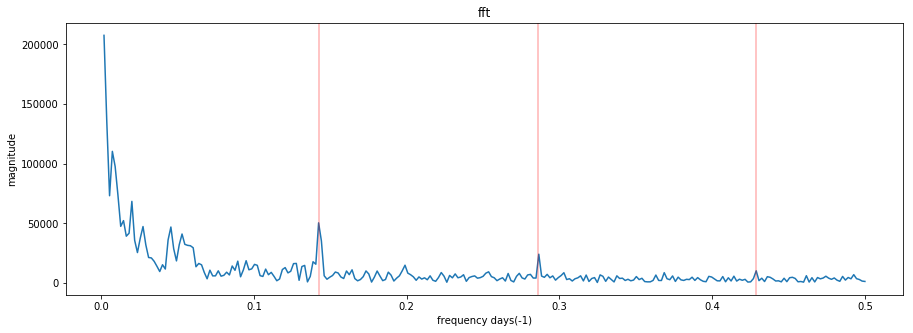

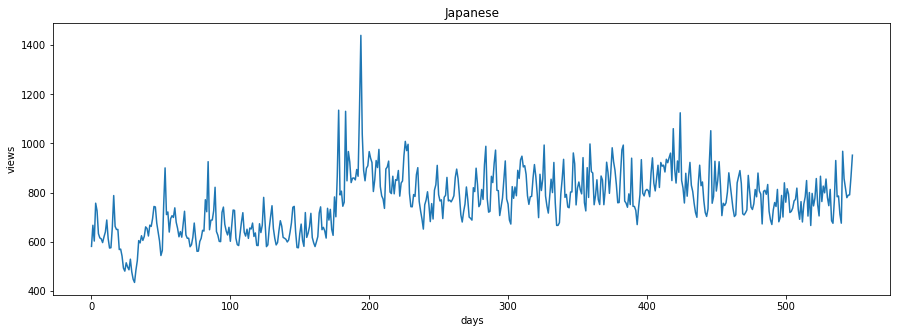

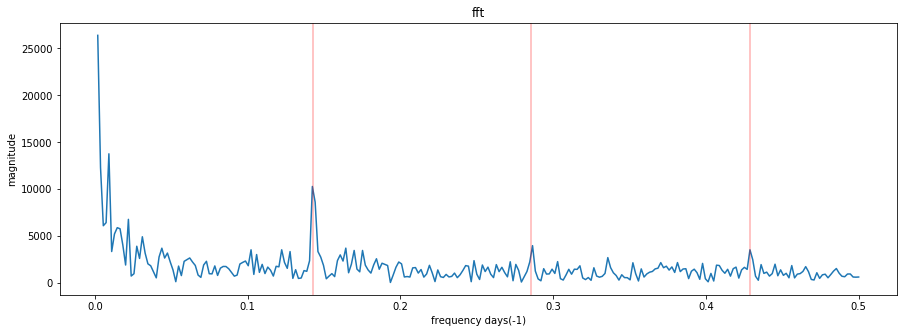

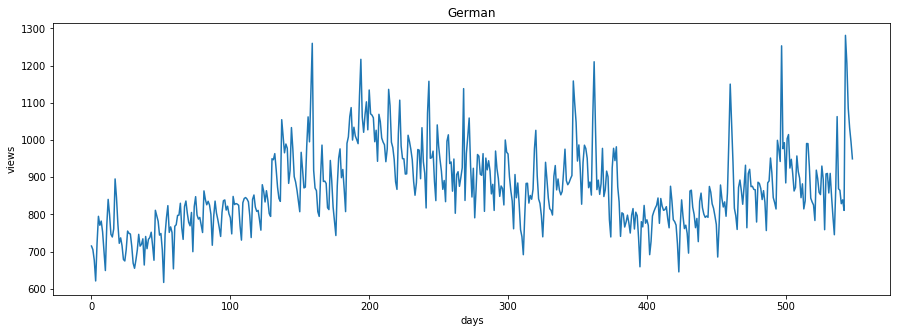

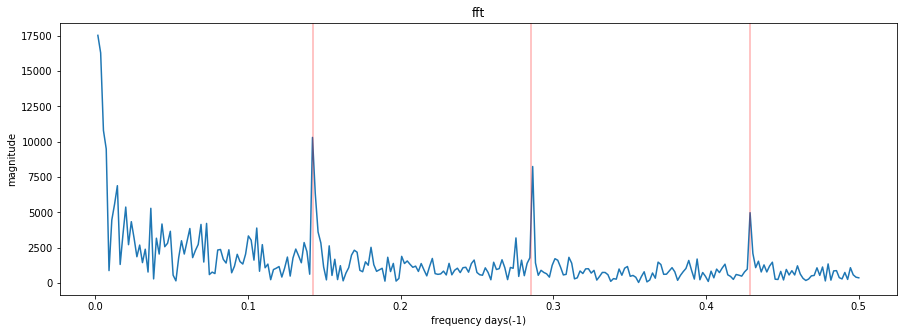

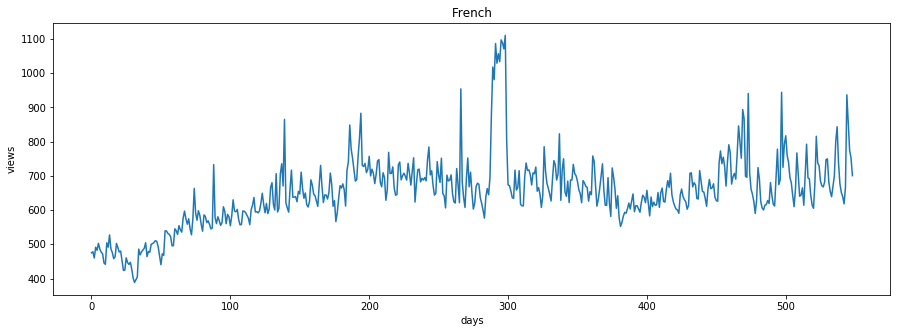

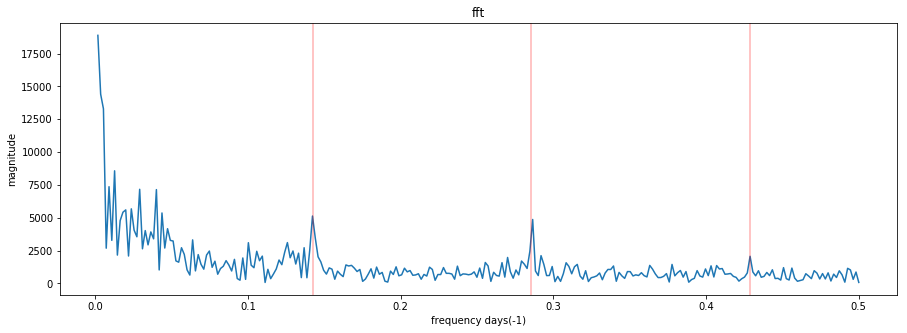

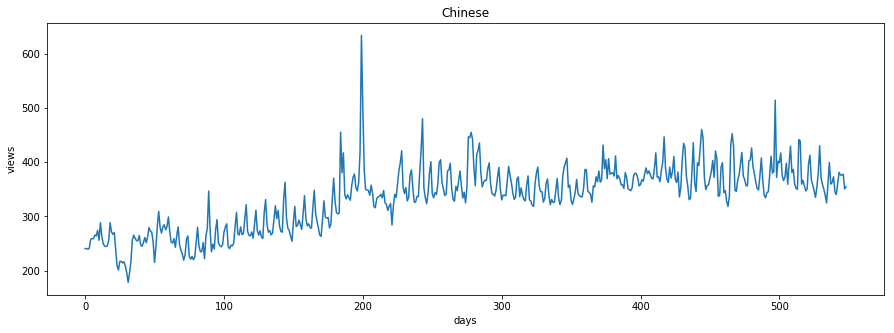

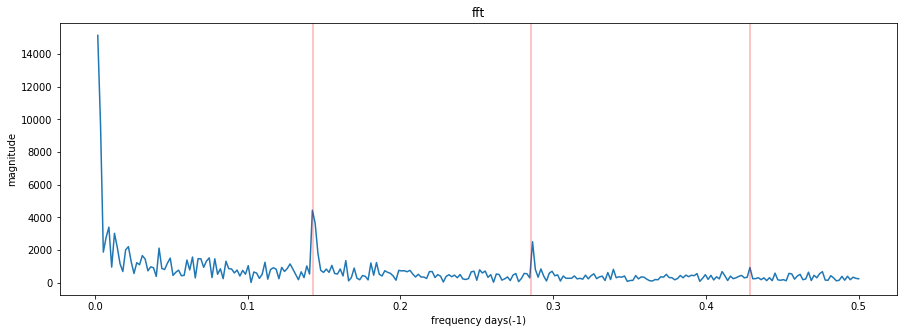

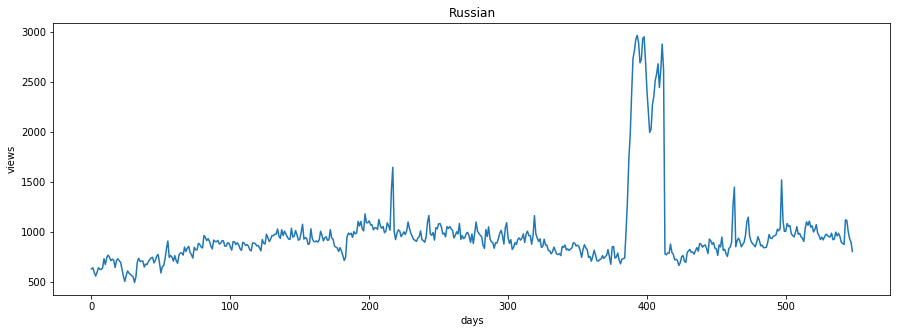

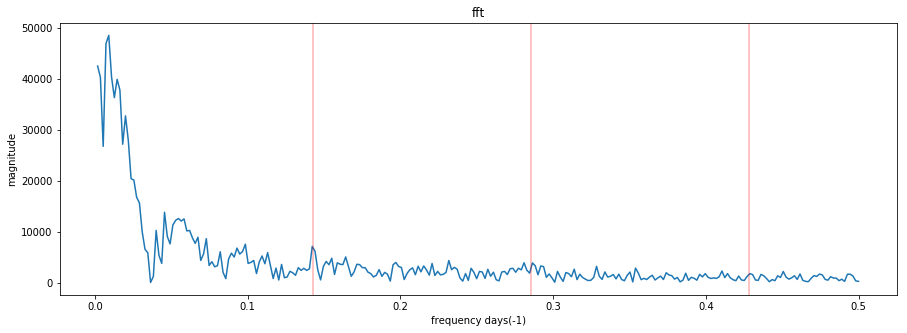

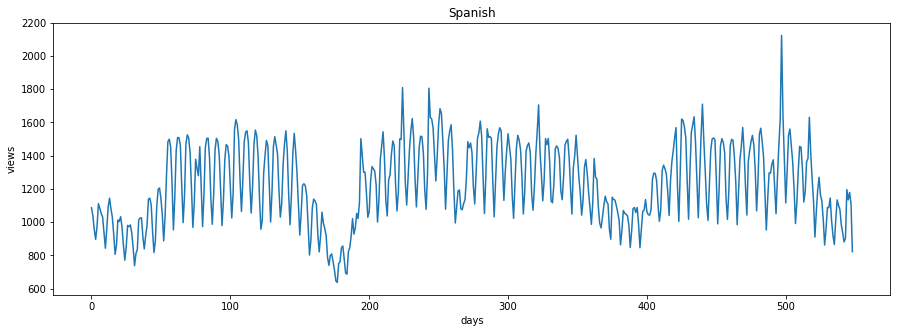

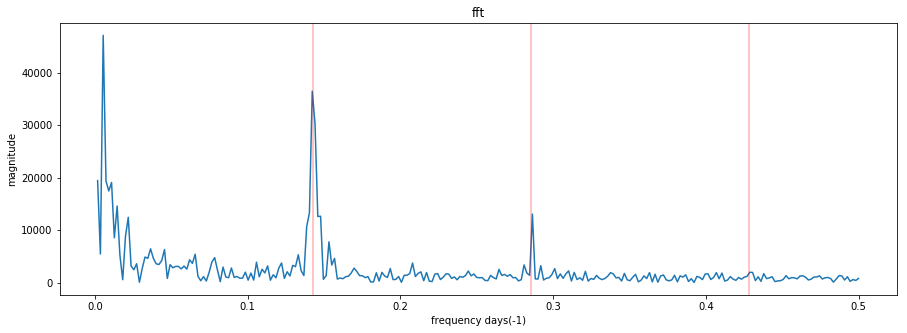

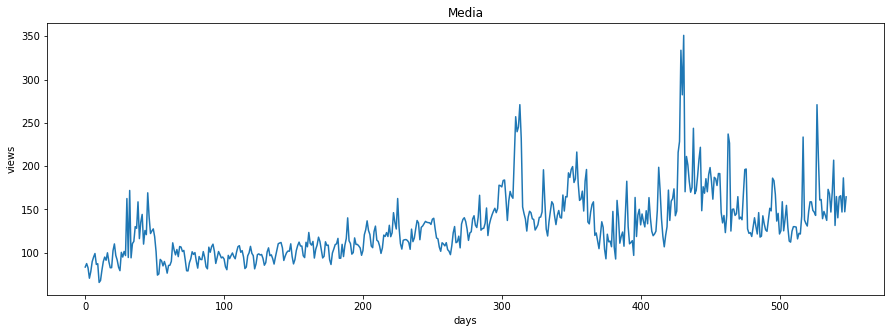

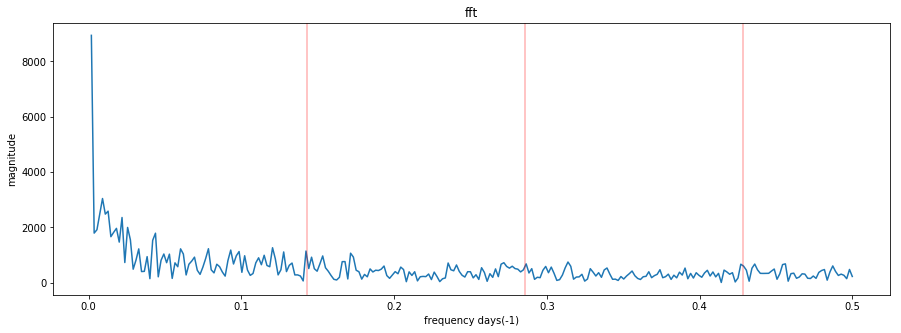

In [53]:
def plot_fft(key):
    
    fig = plt.figure(1, figsize=[15,5]) 
    plt.ylabel('views')
    plt.xlabel('days')
    plt.title(labels[key])
    plt.plot(days, sums[key], label=labels[key])
    
    fig = plt.figure(2, figsize=[15,5]) 
    fft_complex = fft(sums[key])
    fft_mag = [np.sqrt(np.real(x) * np.real(x) + np.imag(x)*np.imag(x)) 
              for x in fft_complex]
    fft_xvals = [day/ days[-1] for day in days]
    
    npts = len(fft_xvals) // 2 + 1
    fft_mag = fft_mag[:npts]
    fft_xvals = fft_xvals[:npts]
    
    plt.ylabel('magnitude')
    plt.xlabel('frequency days(-1)')
    plt.title('fft')
    plt.plot(fft_xvals[1:], fft_mag[1:], label = labels[key])
    
    plt.axvline(x=1./7, color='red', alpha=0.3)
    plt.axvline(x=2./7, color='red', alpha=0.3)
    plt.axvline(x=3./7, color='red', alpha=0.3)
    
    plt.show()
    
for key in sums:
    plot_fft(key)

In [55]:
pickle_out = open('pickle/data.pkl', 'wb')
pickle.dump(data, pickle_out)
pickle_out.close()

In [56]:
pickle_out = open('pickle/top_pages.pkl', 'wb')
pickle.dump(top_pages, pickle_out)
pickle_out.close()

In [57]:
pickle_out = open('pickle/langs.pkl', 'wb')
pickle.dump(lang_sets, pickle_out)
pickle_out.close()

# Autocorrelation

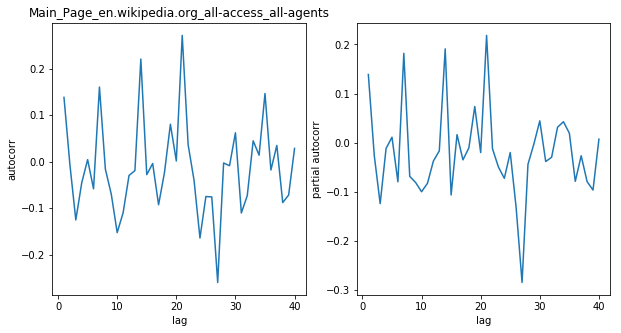

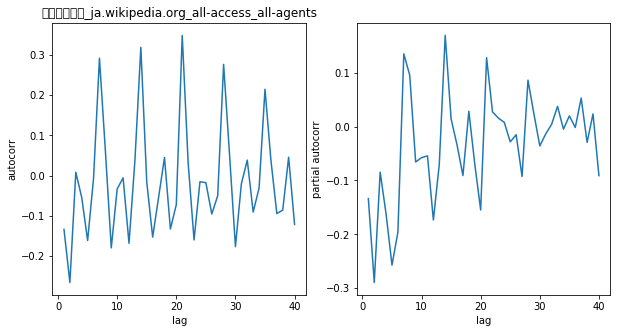

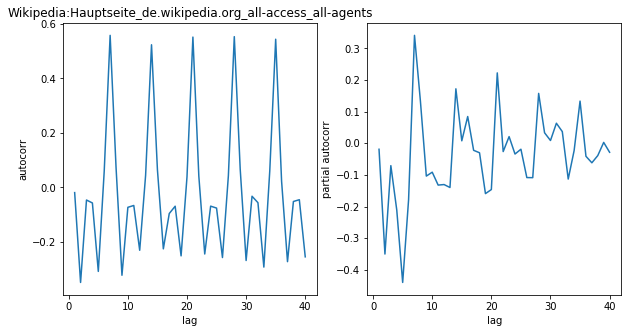

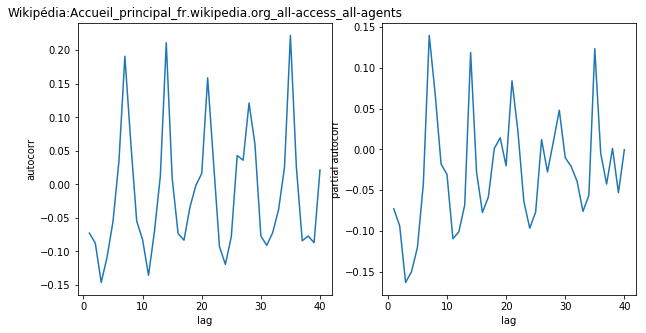

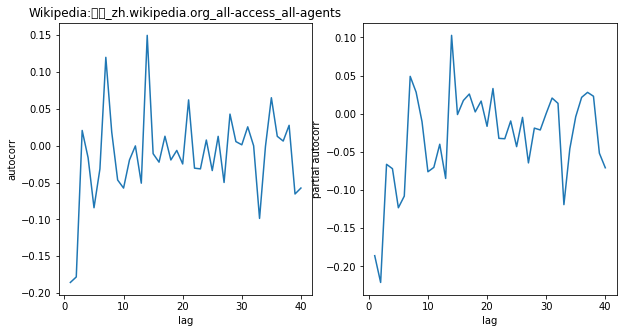

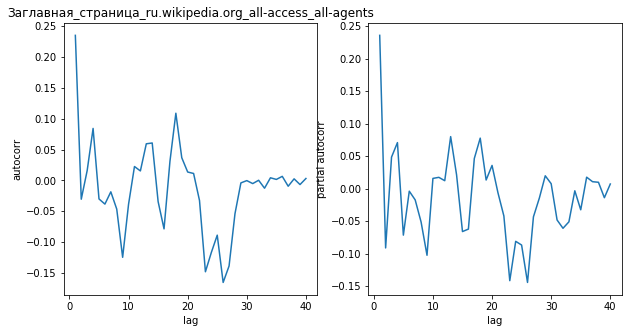

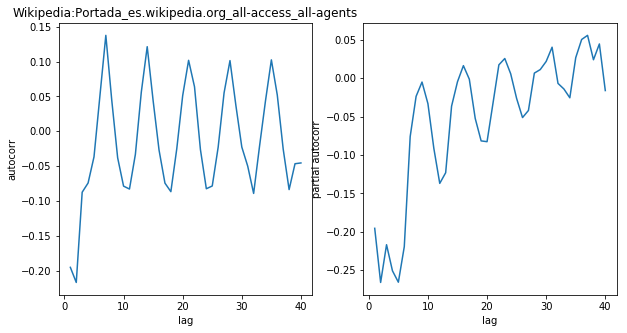

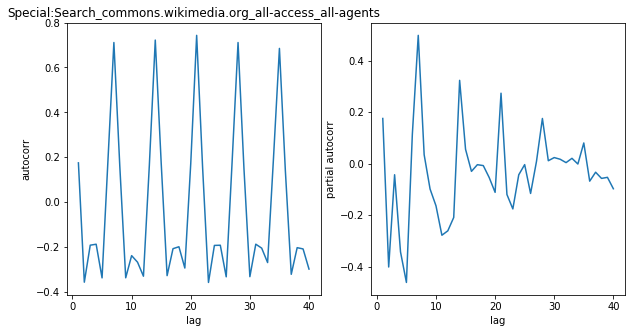

In [58]:
# autocorrelation and partial autocorrelation of top pages
for key in top_pages:
    fig = plt.figure(1, figsize=(10,5))
    ax1 = plt.subplot(121)
    ax2 = plt.subplot(122)
    
    cols = data.columns[1:-2]
    tseries = np.array(data.loc[top_pages[key], cols])
    tseries_diff = [tseries[i] - tseries[i-1] for i in range(1, len(tseries))]
    
    autocorr = acf(tseries_diff)
    pautocorr = pacf(tseries_diff)
    
    x = [x for x in range(len(pautocorr))]
    ax1.plot(x[1:], autocorr[1:])
    ax1.set_xlabel('lag')
    ax1.set_ylabel('autocorr')
    ax1.set_title(data.loc[top_pages[key], 'Page'])
    
    ax2.plot(x[1:], pautocorr[1:])
    ax2.set_xlabel('lag')
    ax2.set_ylabel('partial autocorr')
    plt.show()

# ARIMA

In [59]:
data = pickle.load(open('pickle/data.pkl', 'rb'))
top_pages = pickle.load(open('pickle/top_pages.pkl', 'rb'))
lang_sets = pickle.load(open('pickle/langs.pkl', 'rb'))

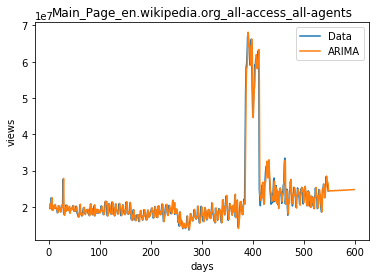

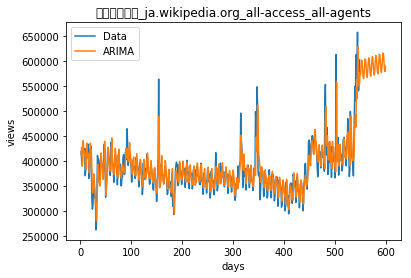

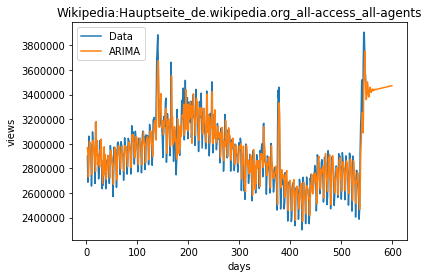

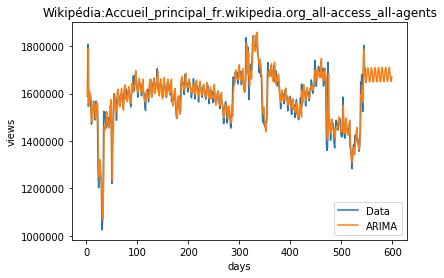

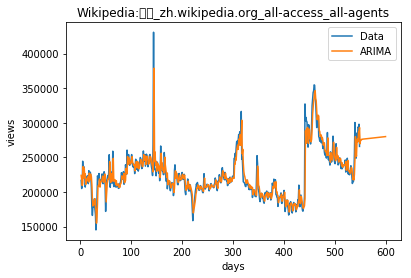

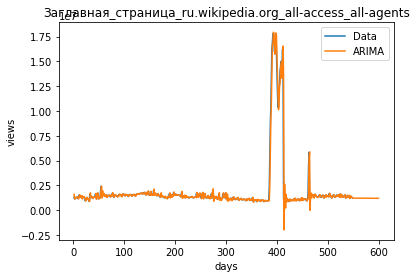

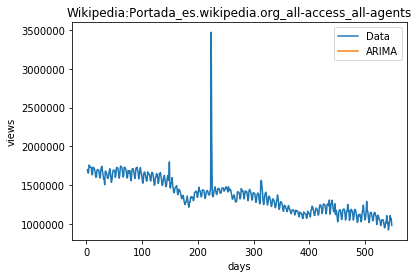

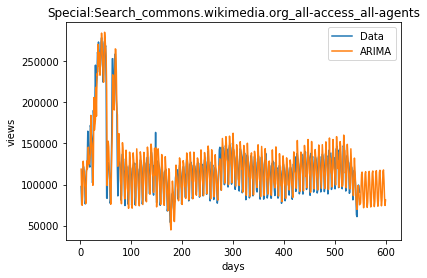

In [60]:
cols = data.columns[1:-2]
for key in top_pages:
    tseries = np.array(data.loc[top_pages[key], cols], 'f')
    result = None
 
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore')
        try:
            arima = ARIMA(tseries,[2,1,4])
            result = arima.fit(disp=False)
 
        except:
            try:

                arima = ARIMA(tseries,[2,1,2])
                result = arima.fit(disp=False)
            except:
                print(data.loc[top_pages[key],'Page'])
                print('\tARIMA failed')

    pred = result.predict(2, 599, typ='levels')

    x = [i for i in range(600)]
    i=0
    
    plt.plot(x[2:len(tseries)], tseries[2:], label='Data')
    plt.plot(x[2:], pred, label='ARIMA')
    plt.title(data.loc[top_pages[key], 'Page'])
    plt.xlabel('days')
    plt.ylabel('views')
    plt.legend()
    plt.show()